# Description
In this project, we use the data from kaggle competition [Toxic Comment Classification Challenge by Jigsaw](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data?select=train.csv.zip) and only use the training data. Then we have break this raw training data into train and test data and evaluate the model performances in test data.

The dataset is taken from wikipedia edit text and is classified as one of the following:

1. toxic
2. severe_toxic
3. obscene
4. threat
5. insult
6. identity_hate

This is a multi-label (not-multiclass) classification. One text row has six labels and exactly one label is 1 and other labels are 0.


References:
- [Hugging face pretrained model names](https://huggingface.co/transformers/pretrained_models.html#pretrained-models)
- [transformers example](https://colab.research.google.com/github/rap12391/transformers_multilabel_toxic/blob/master/toxic_multilabel.ipynb)
- [Kaggle: Fastai with Transformers (BERT, RoBERTa)](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta)


# Deep Learning NLP
Transformers Models
- BERT (from Google)
- XLNet (from Google/CMU)
- XLM (from Facebook)
- RoBERTa (from Facebook)
- DistilBERT (from Hugging Face)

Notes:
1. As we are not using RNN, we have to limit the sequence length to the model input size.
1. Most of the models require special tokens placed at the beginning and end of the sequences.
1. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with add_prefix_space set to True.


```

bert:       [CLS] + tokens + [SEP] + padding

roberta:    [CLS] + prefix_space + tokens + [SEP] + padding

distilbert: [CLS] + tokens + [SEP] + padding

xlm:        [CLS] + tokens + [SEP] + padding

xlnet:      padding + tokens + [SEP] + [CLS]

```

# Load the Libraries

In [1]:
import os
import sys
import time

time_start_notebook = time.time()

In [2]:
%%capture
import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install sentencepiece # xlnet needs this
    !pip install transformers
    !pip install scikit-plot
    !pip install watermark

In [3]:
# data science
import numpy as np
import pandas as pd
from tqdm import tqdm

# visualization
import seaborn as sns
sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# mixed
import os
import time
from pprint import pprint
import joblib
import pickle
from tqdm import tqdm, trange
from ast import literal_eval

# random state
SEED=100
np.random.seed(SEED)

# machine learning
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

# deep learning
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
import transformers
from transformers import *

# model eval
import scikitplot as skplt

# versions
import watermark
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-12-06 

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit

torch                   1.7.0+cu101
numpy                   1.18.5
transformers            4.0.0
seaborn                 0.11.0
matplotlib              3.2.2
sklearn                 0.22.2.post1
scikitplot              0.3.7
watermark               2.0.2
tensorflow              2.3.0
joblib                  0.17.0
pandas                  1.1.4
transformers.file_utils 4.0.0



# Useful Functions

In [4]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

In [5]:
def seed_all(seed):
    import random
    random.seed(seed) # Python
    np.random.seed(seed) # cpu vars
    torch.manual_seed(seed) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [6]:
seed_all(seed=SEED)

# GPU Testing

In [7]:
# We must use gpu for this notebook, it is needed later
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Load Training Data

In [9]:
# %%capture

# # Once you downloaded the data, comment this cell
# download_data = True
# if download_data:
#     !wget https://github.com/bhishanpdl/Datasets/blob/master/Projects/Jigsaw_Toxic_Comment_Classification/train.csv.zip?raw=true
#     !unzip train.csv.zip?raw=true

#     !wget https://github.com/bhishanpdl/Datasets/blob/master/Projects/Jigsaw_Toxic_Comment_Classification/test.csv.zip?raw=true
#     !unzip test.csv.zip?raw=true

In [10]:
os.listdir()

['.config',
 'train.csv',
 'test.csv.zip?raw=true',
 'train.csv.zip?raw=true.1',
 'test.csv',
 'test.csv.zip?raw=true.1',
 'train.csv.zip?raw=true',
 'sample_data']

In [11]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,8d603d50affa1126,"""\nYes, aside, thank you for trying to answer ...",0,0,0,0,0,0
1,8fb3576937b9e0d0,March 2010 (UTC)\n\nThanks! and understood abo...,0,0,0,0,0,0
2,379440e04fb68e27,"""\n\n The Outfield \n\nHahaha - compassion is ...",0,0,0,0,0,0
3,6be4446aac8ae028,Opposition is a source of strength. I believe ...,0,0,0,0,0,0
4,1a2ff7ed958506a3,Please discontinue making those unsupported ch...,0,0,0,0,0,0


In [12]:
col_text = 'comment_text'

# unique text
print('unique text')
print(df_train[col_text].nunique(), df_train.shape[0])

# null values
print('nan text')
df_train.isnull().sum()

unique text
127656 127656
nan text


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [13]:
cols_label = ['toxic', 'severe_toxic', 'obscene',
              'threat', 'insult', 'identity_hate']

In [14]:
print('Count of 1 per label: \n', df_train[cols_label].sum(), '\n') 
print('Count of 0 per label: \n', df_train[cols_label].eq(0).sum())

Count of 1 per label: 
 toxic            12202
severe_toxic      1282
obscene           6782
threat             379
insult            6292
identity_hate     1136
dtype: int64 

Count of 0 per label: 
 toxic            115454
severe_toxic     126374
obscene          120874
threat           127277
insult           121364
identity_hate    126520
dtype: int64


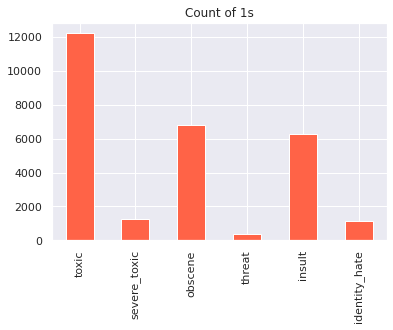

In [15]:
df_train[cols_label].sum().plot.bar(title='Count of 1s',color='tomato');

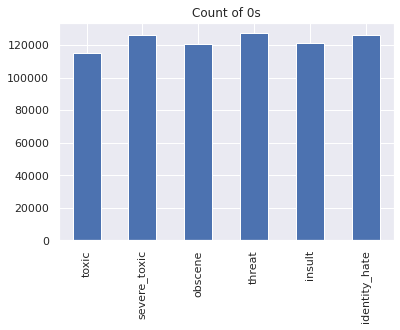

In [16]:
df_train[cols_label].eq(0).sum().plot.bar(title='Count of 0s');

# Data Processing: Training Data

## Shuffle and create ohe column

In [17]:
# shuffle data
df_train = df_train.sample(frac=1,random_state=SEED).reset_index(drop=True)

In [18]:
col_ohe = 'one_hot_labels'
df_train[col_ohe] = df_train[cols_label].to_numpy().tolist()
df_train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
0,815dac68f62b1e6a,"""\n\n Defenestration \n\nIt was previously rep...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,570a66d523877761,I am easily able to trace my lineage back to C...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [19]:
labels    = list(df_train[col_ohe].values)
list_text = list(df_train[col_text].values)

# Choose Transformers Model

In [20]:
model_name = 'distilbertfast'
num_labels = len(cols_label) # NUM_CLASSES

#=======================================================
vocab_file = None
tokenizer = None
model = None
if model_name == 'bert':
    vocab_file = 'bert-base-uncased'
    tokenizer = transformers.BertTokenizer.from_pretrained(
        vocab_file,do_lower_case=True)

    model = transformers.BertForSequenceClassification.from_pretrained(
        vocab_file, num_labels=num_labels)

if model_name == 'distilbertfast':
    vocab_file = 'distilbert-base-uncased'
    tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(
        vocab_file,do_lower_case=True)

    model = transformers.BertForSequenceClassification.from_pretrained(
        vocab_file, num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.

## Load pretrained tokenizer

Transformers pretrained tokenizers

```python
BERT:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

XLNet:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

RoBERTa:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)

DistilBert:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base', do_lower_case=False)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base', do_lower_case=False)
```

transformers.MyTokenizer.from_pretrained
```
from_pretrained(pretrained_model_name_or_path, *init_inputs, **kwargs)

```


Distilbert hugging face: https://huggingface.co/transformers/model_doc/distilbert.html

```python
transformers.DistilBertConfig(
vocab_size=30522,
max_position_embeddings=512,
sinusoidal_pos_embds=False, 
n_layers=6, 
n_heads=12, 
dim=768, 
hidden_dim=3072, 
dropout=0.1, 
attention_dropout=0.1, 
activation='gelu', 
initializer_range=0.02, 
qa_dropout=0.1, 
seq_classif_dropout=0.2, 
pad_token_id=0, 
**kwargs)
```

```python
transformers.DistilBertTokenizerFast(vocab_file,
tokenizer_file=None,
do_lower_case=True,
unk_token='[UNK]',
sep_token='[SEP]',
pad_token='[PAD]',
cls_token='[CLS]',
mask_token='[MASK]',
tokenize_chinese_chars=True,
strip_accents=None,
**kwargs)
```


In [21]:
# show_methods(transformers,3,contains='Tokenizer')

In [22]:
# show_methods(transformers.DistilBertTokenizerFast,2)

In [23]:
# vocab_file = 'distilbert-base-uncased'
# tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(
#     vocab_file,do_lower_case=True)

## Get Encodings from tokenizer

Tokenizer: https://huggingface.co/transformers/main_classes/tokenizer.html
```python
batch_encode_plus(batch_text_or_text_pairs,
add_special_tokens=True,
padding=False,
truncation=False,
max_length=None,
stride=0,
is_split_into_words=False,
pad_to_multiple_of=None,
return_tensors=None,
return_token_type_ids=None,
return_attention_mask=None,
return_overflowing_tokens=False,
return_special_tokens_mask=False,
return_offsets_mapping=False,
return_length=False,
verbose=True,
**kwargs)
```

In [24]:
# help(tokenizer.batch_encode_plus)

In [25]:
%%time
max_length = 100 # choose about 100 for colab
encodings = tokenizer.batch_encode_plus(list_text,
                max_length=max_length,
                truncation=True, # if you choose false, colab will crash
                return_token_type_ids=True,
                padding=True)

print('tokenizer outputs: ', encodings.keys())
 
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

# colab error: Your session crashed after using all available RAM.

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
CPU times: user 52.4 s, sys: 1.17 s, total: 53.6 s
Wall time: 15.9 s


In [26]:
input_ids       = encodings['input_ids']
token_type_ids  = encodings['token_type_ids']
attention_masks = encodings['attention_mask']

## Find One-freq rows to exclude from stratify split

- df\_train has ohe column called `one_hot_labels` having `N_CLASSES` list.
- Find value counts of all ohe rows
- If a row is unique, keep it separate.
- Stratify split other rows
- In the end, combine these one freq rows.

In [27]:
# the ohe col has N_classes in a single list
# if a row is unique, we will not stratify split it.
df_train[col_ohe].head()

0    [0, 0, 0, 0, 0, 0]
1    [0, 0, 0, 0, 0, 0]
2    [0, 0, 0, 0, 0, 0]
3    [0, 0, 0, 0, 0, 0]
4    [0, 0, 0, 0, 0, 0]
Name: one_hot_labels, dtype: object

In [28]:
label_counts = df_train[col_ohe].astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()

cond = df_train[col_ohe].astype(str).isin(one_freq)
one_freq_idxs = df_train[cond].index
one_freq_idxs = sorted(list(one_freq_idxs), reverse=True)

print('df_train label indices with only one instance: ', one_freq_idxs)

df_train label indices with only one instance:  [113097, 57059, 7039]


In [29]:
# get single freq rows
# (we will pop from original data and will combine later)

one_freq_input_ids       = [input_ids.pop(i)       for i in one_freq_idxs]
one_freq_token_types     = [token_type_ids.pop(i)  for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels          = [labels.pop(i)          for i in one_freq_idxs]

# Get train validation tensors

In [30]:
%%time

# train valid split using stratify
# Here we use only ohe rows that have freq count > 1
train_inputs, valid_inputs,\
train_labels, valid_labels,\
train_token_types, valid_token_types,\
train_masks, valid_masks\
  = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                    random_state=SEED,
                    test_size=0.10,
                    stratify = labels)

# After stratify split, we combine back one-freq rows
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

# Create torch tensors
train_inputs      = torch.tensor(train_inputs)
train_labels      = torch.tensor(train_labels)
train_masks       = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

valid_inputs      = torch.tensor(valid_inputs)
valid_labels      = torch.tensor(valid_labels)
valid_masks       = torch.tensor(valid_masks)
valid_token_types = torch.tensor(valid_token_types)

CPU times: user 2.96 s, sys: 70.2 ms, total: 3.03 s
Wall time: 3.03 s


## Get TensorDataset, Sampler and DataLoader
- Random Sampler for train data
- Sequential Sampler for valid data

In [31]:
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

In [32]:
# Select a batch size for training.
# For fine-tuning with XLNet, the authors recommend
# a batch size of 32, 48, or 128.
# We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader.
# This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data       = TensorDataset(train_inputs, train_masks,
                                 train_labels, train_token_types)
train_sampler    = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=batch_size)

valid_data       = TensorDataset(valid_inputs, valid_masks,
                                 valid_labels, valid_token_types)
valid_sampler    = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler,
                              batch_size=batch_size)

In [33]:
# # save data loaders
# torch.save(train_dataloader,'train_data_loader')
# torch.save(valid_dataloader,'valid_data_loader')

## Load the Model for Sequence Classification

```python
BERT:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

XLNet:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

RoBERTa:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
```

In [34]:
show_methods(transformers,contains='SequenceClassification',ncols=2)

,0,1
0,AlbertForSequenceClassification,TFAlbertForSequenceClassification
1,AutoModelForSequenceClassification,TFAutoModelForSequenceClassification
2,BartForSequenceClassification,TFBertForSequenceClassification
3,BertForSequenceClassification,TFCamembertForSequenceClassification
4,CamembertForSequenceClassification,TFDistilBertForSequenceClassification
5,DebertaForSequenceClassification,TFElectraForSequenceClassification
6,DistilBertForSequenceClassification,TFFlaubertForSequenceClassification
7,ElectraForSequenceClassification,TFFunnelForSequenceClassification
8,FlaubertForSequenceClassification,TFLongformerForSequenceClassification
9,FunnelForSequenceClassification,TFMobileBertForSequenceClassification


In [66]:
# %%time

# # num_labels = len(cols_label) # NUM_CLASSES
# # model = transformers.BertForSequenceClassification.from_pretrained(
# #     vocab_file, num_labels=num_labels)

model.cuda()
print('using cuda')

using cuda


In [36]:
show_methods(model)

,0,1,2,3
0,T_destination,device,greedy_search,register_buffer
1,add_memory_hooks,double,half,register_forward_hook
2,add_module,dropout,init_weights,register_forward_pre_hook
3,adjust_logits_during_generation,dtype,invert_attention_mask,register_parameter
4,apply,dummy_inputs,load_state_dict,requires_grad_
5,base_model,dump_patches,load_tf_weights,reset_memory_hooks_state
6,base_model_prefix,estimate_tokens,modules,resize_token_embeddings
7,beam_sample,eval,name_or_path,sample
8,beam_search,extra_repr,named_buffers,save_pretrained
9,bert,float,named_children,set_input_embeddings


## Choose Optimizer

Optimizer AdamW
- https://huggingface.co/transformers/main_classes/optimizer_schedules.html

```python
classtransformers.AdamW(params,
lr          : 0.001,
betas       : 0.9, 0.999,
eps         : 1e-06,
weight_decay:  0.0,
correct_bias: True
)
```

In [37]:
show_methods(transformers,3,contains='Adam')

,0,1,2
0,AdamW,AdamWeightDecay,


In [38]:
# setting custom optimization parameters.
params_opt = list(model.named_parameters()) # this is a list

no_decay = ['bias', 'gamma', 'beta']


params_opt_group = [
    # non decay params
    {'params': [p for n, p in params_opt
                if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},

    # decay params
    {'params': [p for n, p in params_opt
                if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [39]:
print(len(params_opt))
# print(params_opt[0])
print(params_opt[-1])

201
('classifier.bias', Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True))


In [40]:
params_opt[0][0] # key is string

'bert.embeddings.word_embeddings.weight'

In [41]:
params_opt[0][1][0][:2] # value is tensor

tensor([ 0.0015, -0.0127], device='cuda:0', grad_fn=<SliceBackward>)

In [42]:
optimizer = transformers.AdamW(params_opt_group,lr=2e-5,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

## Train Model using Torch

BCE with Logit Loss
- https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
```python
torch.nn.BCEWithLogitsLoss(weight: None,
size_average=None,
reduce=None,
reduction:'mean',
pos_weight:None
)
```

In [43]:
from torch.nn import BCEWithLogitsLoss, BCELoss
from tqdm import trange

In [44]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4 for xlnet)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  
  # train model
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(b.to(device) for b in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch

    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None,
    #                  attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss()
    loss = loss_func(logits.view(-1,num_labels),
                     b_labels.type_as(logits).view(-1,num_labels))
    # loss_func = BCELoss() 
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),
    #             b_labels.type_as(logits).view(-1,num_labels))
    train_loss_set.append(loss.item())    

    # Backward pass
    loss.backward()

    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()

    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  #=======================================================================
  for i, batch in enumerate(valid_dataloader):
    batch = tuple(b.to(device) for b in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch

    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None,
                   attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  #========================================================================
  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.07192983261874426


Epoch:  33%|███▎      | 1/3 [16:54<33:49, 1014.81s/it]

F1 Validation Accuracy:  64.4510657804263
Flat Validation Accuracy:  91.540028199906
Train loss: 0.050434639209280256


Epoch:  67%|██████▋   | 2/3 [33:48<16:54, 1014.52s/it]

F1 Validation Accuracy:  73.57074109720885
Flat Validation Accuracy:  92.0491931693561
Train loss: 0.045808715516655565


Epoch: 100%|██████████| 3/3 [50:42<00:00, 1014.23s/it]

F1 Validation Accuracy:  70.7133917396746
Flat Validation Accuracy:  92.02569324768918


In [45]:
#  torch.save(model.state_dict(), 'bert_model_toxic')

## Load and Preprocess Test Data

In [46]:
cols_label

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [47]:
df_test = pd.read_csv('test.csv')
df_test.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,70bbc3e96dd459b1,"Hammed it is, cheers!",0,0,0,0,0,0
1,0b2e86f819b4b9a4,"Not a problem, sorry for the inconvenience and...",0,0,0,0,0,0


In [48]:
print('Count of 1 per label: \n', df_test[cols_label].sum(), '\n') 
print('Count of 0 per label: \n', df_test[cols_label].eq(0).sum())

Count of 1 per label: 
 toxic            3092
severe_toxic      313
obscene          1667
threat             99
insult           1585
identity_hate     269
dtype: int64 

Count of 0 per label: 
 toxic            28823
severe_toxic     31602
obscene          30248
threat           31816
insult           30330
identity_hate    31646
dtype: int64


In [49]:
df_test.isna().sum().sum()

0

In [50]:
df_test[col_ohe] = df_test[cols_label].to_numpy().tolist()
df_test.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
0,70bbc3e96dd459b1,"Hammed it is, cheers!",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,0b2e86f819b4b9a4,"Not a problem, sorry for the inconvenience and...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [51]:
# Gathering input data
test_labels   = list(df_test[cols_label].values)
test_comments = list(df_test[col_text].values)

## Tokenize Test Data

In [52]:
%%time
# Encoding input data
test_encodings       = tokenizer.batch_encode_plus(test_comments,
                                max_length=max_length,
                                return_token_type_ids=True,
                                pad_to_max_length=True)
test_input_ids       = test_encodings['input_ids']
test_token_type_ids  = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


CPU times: user 11.4 s, sys: 50.6 ms, total: 11.5 s
Wall time: 3.18 s


## Create Tensors for Test Data

In [53]:
# Make tensors out of data
test_inputs      = torch.tensor(test_input_ids)
test_labels      = torch.tensor(test_labels)
test_masks       = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)

## Create DataLoader for Test Data

In [54]:
# Create test dataloader
test_data       = TensorDataset(test_inputs, test_masks, test_labels,
                                test_token_types)
test_sampler    = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=batch_size)

# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

## Get the Predictions from Test Data

In [55]:
%%time
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(b.to(device) for b in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch

  with torch.no_grad():
    # Forward pass
    outs         = model(b_input_ids, token_type_ids=None,
                         attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label   = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label   = pred_label.to('cpu').numpy()
    b_labels     = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item  for sublist in tokenized_texts for item in sublist]
pred_labels     = [item  for sublist in pred_labels     for item in sublist]
true_labels     = [item  for sublist in true_labels     for item in sublist]
true_bools      = [tl==1 for tl      in true_labels]

CPU times: user 58.9 s, sys: 30.6 s, total: 1min 29s
Wall time: 1min 29s


In [56]:
print('pred_lables', pred_labels[:2])
print('true_lables', true_labels[:2])
print('true_bools', true_bools[:2])

pred_lables [array([2.11265427e-03, 9.95524388e-05, 7.45381229e-04, 1.11659254e-04,
       6.03488996e-04, 2.03356976e-04], dtype=float32), array([0.00150312, 0.00014245, 0.00088974, 0.00013881, 0.00066261,
       0.00023769], dtype=float32)]
true_lables [array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])]
true_bools [array([False, False, False, False, False, False]), array([False, False, False, False, False, False])]


# Model Evaluation

In [57]:
len(true_bools), df_test.shape

(31915, (31915, 9))

In [58]:
pred_bools = [pl>0.50 for pl in pred_labels]

In [59]:
f1= f1_score(true_bools, pred_bools,average='micro')
acc = accuracy_score(true_bools, pred_bools)

print(f'F1-score (micro)  : {f1:.4f}')
print(f'Accuracy (overall): {acc:.4f}')

F1-score (micro)  : 0.7005
Accuracy (overall): 0.9185


## Confusion Matrix

In [60]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(true_bools, pred_bools)
mcm

array([[[28619,   204],
        [ 1115,  1977]],

       [[31599,     3],
        [  306,     7]],

       [[30068,   180],
        [  483,  1184]],

       [[31816,     0],
        [   99,     0]],

       [[29977,   353],
        [  568,  1017]],

       [[31642,     4],
        [  266,     3]]])

## Classification Report

In [61]:
clf_report = classification_report(true_bools,pred_bools,
                                   target_names=cols_label)

print(clf_report)

               precision    recall  f1-score   support

        toxic       0.91      0.64      0.75      3092
 severe_toxic       0.70      0.02      0.04       313
      obscene       0.87      0.71      0.78      1667
       threat       0.00      0.00      0.00        99
       insult       0.74      0.64      0.69      1585
identity_hate       0.43      0.01      0.02       269

    micro avg       0.85      0.60      0.70      7025
    macro avg       0.61      0.34      0.38      7025
 weighted avg       0.82      0.60      0.67      7025
  samples avg       0.06      0.05      0.05      7025



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Co-occurence Matrix

In [62]:
def get_df_coo(y_true,y_pred,column_names):
    """
    Get Co-occurence matrix from test labels and predictions.
    """
    yt = np.array(y_true,dtype=np.int32)
    yp = np.array(y_pred,dtype=np.int32)
    coo = yt.T.dot(yp)
    df_coo = pd.DataFrame(coo, columns=column_names,index=column_names)
    df_coo.loc['Total']= df_coo.sum(numeric_only=True, axis=0)
    df_coo.loc[:,'Total'] = df_coo.sum(numeric_only=True, axis=1)
    df_coo = df_coo.astype(np.int32)
    return df_coo

In [63]:
def highlight_diagf(dfx, color="khaki"):
    def highlight_diag(dfy):
        a = np.full(dfy.shape, "", dtype="<U24")
        np.fill_diagonal(a, f"background-color: {color}")
        df1 = pd.DataFrame(a, index=dfy.index, columns=dfy.columns)
        return df1

    return dfx.style.apply(highlight_diag, axis=None)

In [64]:
df_coo = get_df_coo(true_bools,pred_bools,column_names=cols_label)
highlight_diagf(df_coo)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,Total
toxic,1977,10,1313,0,1335,7,4642
severe_toxic,309,7,288,0,297,1,902
obscene,1457,10,1184,0,1163,1,3815
threat,76,0,51,0,58,0,185
insult,1316,10,964,0,1017,0,3307
identity_hate,215,1,151,0,169,3,539
Total,5350,38,3951,0,4039,12,13390


# Time Taken

In [65]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

# Time taken to run whole notebook: 1 hr 10 min 31 secs

Time taken to run whole notebook: 0 hr 53 min 13 secs
